## handmade vanila RNN

In [1]:
# ref http://blog.csdn.net/liuchonge/article/details/70809288
import tensorflow as tf
import numpy as np

######################
# model construction #
######################

batch_size = 20
num_step = 30
state_size = 100
num_class = 2
learning_rate = 0.001

x = tf.placeholder(tf.int32, [batch_size, num_step], name="input_placeholder")
y = tf.placeholder(tf.int32, [batch_size, num_step], name="output_placeholder")

x_one_hot = tf.one_hot(x, num_class)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

with tf.variable_scope("rnn_cell"):
    W = tf.get_variable("W", [num_class + state_size, state_size])
    b = tf.get_variable("b", [state_size], initializer=tf.constant_initializer(0.0))

def rnn_cell(rnn_input, state):
    with tf.variable_scope("rnn_cell", reuse=True):
        W = tf.get_variable("W", [num_class + state_size, state_size])
        b = tf.get_variable("b", [state_size], initializer=tf.constant_initializer(0.0))
    return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)

rnn_outputs = []
state = tf.zeros([batch_size, state_size])
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)

with tf.variable_scope("softmax"):
    W = tf.get_variable("W", [state_size, num_class])
    b = tf.get_variable("b", [num_class])

logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = tf.unstack(y, axis=1)

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
optimizer = tf.train.AdamOptimizer().minimize(total_loss)
init = tf.global_variables_initializer()

Average loss at step 50 for last 50 steps is 0.3757792916893959
Average loss at step 100 for last 50 steps is 0.11165374793112277
Average loss at step 150 for last 50 steps is 0.03906390625983477
Average loss at step 200 for last 50 steps is 0.018498285561800002
Average loss at step 250 for last 50 steps is 0.010696770697832108
Average loss at step 300 for last 50 steps is 0.006974773248657584
Average loss at step 350 for last 50 steps is 0.0049118486884981395
Average loss at step 400 for last 50 steps is 0.0036473437352105976
Average loss at step 450 for last 50 steps is 0.002818048680201173
30
[ 0.00228096  0.99771899] 1
[ 0.9978441   0.00215586] 0
[ 0.00207699  0.99792308] 1
[ 0.99796677  0.00203324] 0
[ 0.99797505  0.002025  ] 0
[ 0.9980616  0.0019384] 0
[ 0.99796104  0.00203894] 0
[ 0.00208385  0.99791616] 1
[ 0.00205249  0.99794751] 1
[ 0.9979673   0.00203262] 0
[ 0.00200386  0.99799621] 1
[ 0.00207768  0.99792236] 1
[ 0.99801111  0.00198883] 0
[ 0.00202809  0.99797195] 1
[ 0.998

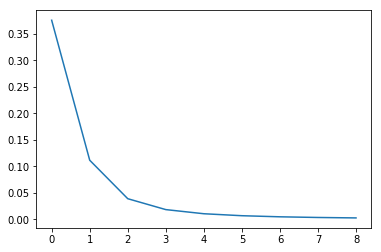

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def gen_epoch(n, batch_size, num_step, num_class, seed):
    """generate each bathc for one epoch
    Parameters
    ----------
    n: int
        number of total instance
    num_step: int
        length of sequence
    seed: int
        random seed
    """
    def gen_sequence(num_step, num_class):
        """generate a sequence pair"""
        x = np.random.choice(num_class, size=(num_step,))
        y = x.copy()
        return x, y

    def gen_batch(batch_size, num_step, num_class):
        """generate data in for one batch"""
        batch_x = np.zeros((batch_size, num_step), dtype=np.int32)
        batch_y = np.zeros((batch_size, num_step), dtype=np.int32)

        for i in range(batch_size):
            raw_x, raw_y = gen_sequence(num_step, num_class)
            batch_x[i] = raw_x
            batch_y[i] = raw_y
        return batch_x, batch_y
    
    np.random.seed(random_seed)

    for i in range(n // batch_size):
        yield gen_batch(batch_size, num_step, num_class)

        
if __name__ == "__main__":
    ###################
    # model execution #
    ###################

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    sess.run(init)
  
    num_instance = 10000
    num_class = 2
    num_epoch = 1
    random_seed = 1337

    tf.set_random_seed(random_seed)
    training_losses = []
    
    for i in range(num_epoch):
        step = 0
        training_loss = 0
        for batch_x, batch_y in gen_epoch(num_instance, batch_size, num_step, num_class, random_seed):
            _, training_loss_ = sess.run([optimizer, total_loss], feed_dict={x: batch_x, y: batch_y})
            training_loss += training_loss_
            if step % 50 == 0 and step > 0:
                print("Average loss at step {} for last 50 steps is {}".format(step, training_loss / 50))
                training_losses.append(training_loss / 50)
                training_loss = 0
            step += 1
    
    training_rnn_inputs, training_predictions = sess.run(
        [rnn_inputs, predictions],
        feed_dict={x: batch_x, y: batch_y}
    )
    print(len(training_rnn_inputs))
    for i in range(len(training_predictions)):
        print(training_predictions[i][0], batch_x[0][i])
    plt.plot(training_losses)
    plt.show()

# tensorflow build-in RNN

In [1]:
import tensorflow as tf
import numpy as np

######################
# model construction #
######################

batch_size = 20
num_step = 30
state_size = 100
num_class = 2
learning_rate = 0.001

x = tf.placeholder(tf.int32, [batch_size, num_step], name="input_placeholder")
y = tf.placeholder(tf.int32, [batch_size, num_step], name="output_placeholder")

x_one_hot = tf.one_hot(x, num_class)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

cell = tf.contrib.rnn.BasicRNNCell(state_size)
state = tf.zeros([batch_size, state_size])
rnn_outputs, final_state = tf.contrib.rnn.static_rnn(cell, rnn_inputs, initial_state=state)

with tf.variable_scope("softmax"):
    W = tf.get_variable("W", [state_size, num_class])
    b = tf.get_variable("b", [num_class])

logits = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

y_as_list = tf.unstack(y, axis=1)

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
optimizer = tf.train.AdamOptimizer().minimize(total_loss)
init = tf.global_variables_initializer()

Average loss at step 50 for last 50 steps is 0.604506931900978
Average loss at step 100 for last 50 steps is 0.23648495584726334
Average loss at step 150 for last 50 steps is 0.09437926419079304
Average loss at step 200 for last 50 steps is 0.044342922046780586
Average loss at step 250 for last 50 steps is 0.024959750883281232
Average loss at step 300 for last 50 steps is 0.01587617864832282
Average loss at step 350 for last 50 steps is 0.011076170764863492
Average loss at step 400 for last 50 steps is 0.008154754396528005
Average loss at step 450 for last 50 steps is 0.006267379596829414
Average loss at step 50 for last 50 steps is 0.004122598543763161
Average loss at step 100 for last 50 steps is 0.0033451904077082873
Average loss at step 150 for last 50 steps is 0.002811950780451298
Average loss at step 200 for last 50 steps is 0.0024074929999187587
Average loss at step 250 for last 50 steps is 0.002082293028943241
Average loss at step 300 for last 50 steps is 0.0018104443186894058


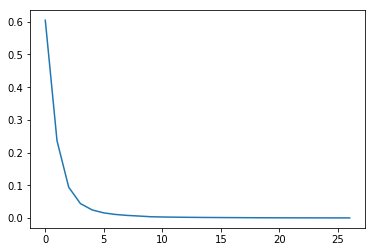

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

def gen_epoch(n, batch_size, num_step, num_class, seed):
    """generate each bathc for one epoch
    Parameters
    ----------
    n: int
        number of total instance
    num_step: int
        length of sequence
    seed: int
        random seed
    """
    def gen_sequence(num_step, num_class):
        """generate a sequence pair"""
        x = np.random.choice(num_class, size=(num_step,))
        y = x.copy()
        return x, y

    def gen_batch(batch_size, num_step, num_class):
        """generate data in for one batch"""
        batch_x = np.zeros((batch_size, num_step), dtype=np.int32)
        batch_y = np.zeros((batch_size, num_step), dtype=np.int32)

        for i in range(batch_size):
            raw_x, raw_y = gen_sequence(num_step, num_class)
            batch_x[i] = raw_x
            batch_y[i] = raw_y
        return batch_x, batch_y
    
    np.random.seed(random_seed)

    for i in range(n // batch_size):
        yield gen_batch(batch_size, num_step, num_class)

        
if __name__ == "__main__":
    ###################
    # model execution #
    ###################

    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.1)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    sess.run(init)
  
    num_instance = 10000
    num_class = 2
    num_epoch = 3
    random_seed = 1337

    tf.set_random_seed(random_seed)
    training_losses = []
    
    for i in range(num_epoch):
        step = 0
        training_loss = 0
        for batch_x, batch_y in gen_epoch(num_instance, batch_size, num_step, num_class, random_seed):
            _, training_loss_ = sess.run([optimizer, total_loss], feed_dict={x: batch_x, y: batch_y})
            training_loss += training_loss_
            if step % 50 == 0 and step > 0:
                print("Average loss at step {} for last 50 steps is {}".format(step, training_loss / 50))
                training_losses.append(training_loss / 50)
                training_loss = 0
            step += 1
    
    training_rnn_inputs, training_predictions = sess.run(
        [rnn_inputs, predictions],
        feed_dict={x: batch_x, y: batch_y}
    )
    print(len(training_rnn_inputs))
    for i in range(len(training_predictions)):
        print(training_predictions[i][0], batch_x[0][i])
    plt.plot(training_losses)
    plt.show()